# Libraries Used

- Keras
- Numpy
- Train Test Split, Shuffle, Confusion Matrix from SKLEARN,
- MatPlotLib for visualization,
- Seaborn for background and confusion matrix visualization,
- Pandas dataframes for confusion matrix,
- CV2 to read images,
- TQDM For proccess visualization,
- Drive mount from Google Colab
- OS to loop through folders

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from google.colab import drive
from tensorflow import keras
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os

%matplotlib inline

# Reading Images
1. Mount HackathonDataset from Google Drive
2. Loop through each folder

In [3]:
drive.mount("/content/drive/")
dir = "/content/drive/MyDrive/HackathonDataset"

Mounted at /content/drive/


In [4]:
# @return x_train, y_train
def load_data():
  images, labels, errors, names, j, bar = [], [], [], {}, 0, tqdm(total=21065, position=0)
  for label in os.listdir(dir):
    if os.path.isdir(os.path.join(dir, label)):
      for img in os.listdir(os.path.join(dir, label)):
        try:
          image = cv2.imread(os.path.join(dir, label, img), 0) # grayscale mode
          # image = cv2.resize(image, (28, 28)) # 48x48 -> 28x28
          images.append(image)
          labels.append(j)
        except:
          errors.append(img)
        bar.update(1)
      names[j] = f"{label}"
      j += 1
      
  bar.close()
  print()
  for err in errors:
    print(f"Error: {err}")
  for k, v in names.items():
    print(f"{k}: {v}")

  return np.array(images), np.array(labels)

# Preprocessing

1. Reshape x_train as (len, 48*48) (flatten images)
2. Divide every value by 255
4. Split data into train, test, and validation (90%, 5%, 5%)
5. Reshape images into 4D (len, 48, 48, 1) for convolutions
6. Shuffle images and labels
- @return x_train, x_test, x_val, y_train, y_test, y_val

In [5]:
def preprocess(x_train, y_train):
  # scaler = MinMaxScaler()
  x_train = x_train.reshape(x_train.shape[0], 48 ** 2)
  y_train = keras.utils.to_categorical(y_train, num_classes=4)
  # x_train = scaler.fit_transform(x_train)
  x_train = x_train / 255
  x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1)
  x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
  # x_train, y_train = SMOTE().fit_resample(x_train, y_train)
  x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
  x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
  x_val = x_val.reshape(x_val.shape[0], 48, 48, 1)
  x_train, y_train = shuffle(x_train, y_train)
  x_test, y_test = shuffle(x_test, y_test)
  x_val, y_val = shuffle(x_val, y_val)
  return x_train, x_test, x_val, y_train, y_test, y_val

# Model Building

In [6]:
def get_model():
  model = keras.Sequential([
                            keras.layers.InputLayer(input_shape=(48, 48, 1)),
                            keras.layers.Conv2D(64, (5, 5), padding='same', kernel_initializer='he_normal'),
                            keras.layers.MaxPool2D((2, 2), padding='same'),
                            keras.layers.Activation('relu'),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.35),

                            keras.layers.Conv2D(64, (5, 5), padding='same', kernel_initializer='he_normal'),
                            keras.layers.MaxPool2D((2, 2), padding='same'),
                            keras.layers.Activation('relu'),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.35),

                            keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
                            keras.layers.MaxPool2D((2, 2), padding='same'),
                            keras.layers.Activation('relu'),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.35),

                            keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
                            keras.layers.Activation('relu'),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.35),

                            keras.layers.Flatten(),

                            keras.layers.Dense(128, kernel_initializer='he_normal'),
                            keras.layers.Activation('relu'),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.35),

                            keras.layers.Dense(128, kernel_initializer='he_normal'),
                            keras.layers.Activation('relu'),
                            keras.layers.BatchNormalization(),
                            keras.layers.Dropout(0.35),

                            keras.layers.Dense(4),
                            keras.layers.Activation('softmax')
  ])

  model.compile(
      optimizer = 'adam',
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
    )
 
  return model

# Callbacks

In [7]:
def get_callbacks():

  def decay(epoch):

    initial_lr = 0.1

    def exp_decay(x):
      return initial_lr * np.exp(-0.1 * x)

    def step_decay(x):
      start = exp_decay(5)
      k = 0.5
      epoch_k = 10
      return start * (k ** np.floor((x + 1) / epoch_k))
    
    if epoch <= 5:
      return exp_decay(epoch)
    elif epoch < 100:
      return step_decay(epoch)
    return 0.0125 / epoch

  optimization_manager = keras.callbacks.LearningRateScheduler(decay)
  # checkpoint_manager = keras.callbacks.ModelCheckpoint(
      # "model.h5",
      # monitor='val_loss',
      # verbose=0,
      # save_best_only=True,
      # )

  return [optimization_manager]

# Training

In [8]:
x_train, x_test, x_val, y_train, y_test, y_val = preprocess(*load_data())

100%|██████████| 21065/21065 [08:23<00:00, 41.80it/s] 



0: angry
1: happy
2: neutral
3: sad


In [9]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 activation (Activation)     (None, 24, 24, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        1

In [10]:
history = model.fit(
    x_train,
    y_train,
    batch_size = 32,
    validation_data = (x_val, y_val),
    callbacks = get_callbacks(),
    epochs = 100
)

Epoch 1/100
593/593 [==============================] - 24s 19ms/step - loss: 1.5571 - accuracy: 0.2915 - val_loss: 1.7721 - val_accuracy: 0.3529 - lr: 0.1000
Epoch 2/100
593/593 [==============================] - 11s 18ms/step - loss: 1.4790 - accuracy: 0.3006 - val_loss: 1.3856 - val_accuracy: 0.3463 - lr: 0.0905
Epoch 3/100
593/593 [==============================] - 11s 18ms/step - loss: 1.4823 - accuracy: 0.2981 - val_loss: 2.0540 - val_accuracy: 0.3074 - lr: 0.0819
Epoch 4/100
593/593 [==============================] - 10s 18ms/step - loss: 1.4430 - accuracy: 0.3038 - val_loss: 1.4260 - val_accuracy: 0.2097 - lr: 0.0741
Epoch 5/100
593/593 [==============================] - 11s 18ms/step - loss: 1.4248 - accuracy: 0.3086 - val_loss: 1.5262 - val_accuracy: 0.3615 - lr: 0.0670
Epoch 6/100
593/593 [==============================] - 11s 18ms/step - loss: 1.4305 - accuracy: 0.3044 - val_loss: 1.4161 - val_accuracy: 0.3055 - lr: 0.0607
Epoch 7/100
593/593 [==============================]

In [33]:
predictions = model.predict(x_test)
model.evaluate(x_test, y_test)

33/33 [==============================] - 0s 9ms/step - loss: 0.8303 - accuracy: 0.6638


[0.8303011655807495, 0.6638176441192627]

In [13]:
model.save("model.h5")

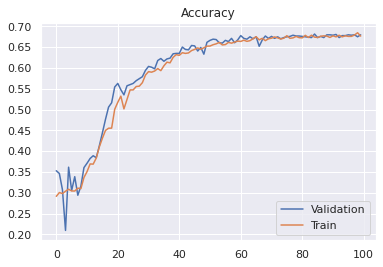

In [95]:
sns.set()
plt.yticks(np.arange(0, 1, 0.05))
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title("Accuracy")
plt.legend(["Validation", "Train"], loc='lower right')

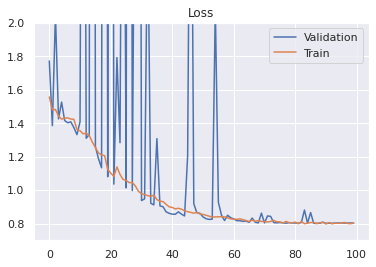

In [28]:
plt.gca().set_ylim([0.7, 2])
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title("Loss")
plt.legend(["Validation", "Train"], loc='upper right')

Text(0.5, 12.5, 'Predicted')

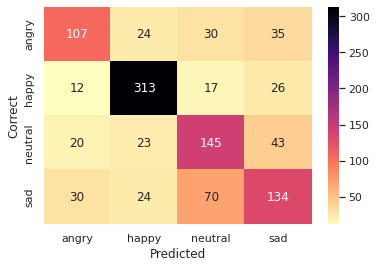

In [115]:
matrix = confusion_matrix(
    [np.argmax(pred) for pred in y_test],
    [np.argmax(pred) for pred in predictions],
)

map = pd.DataFrame(
    matrix,
    ["angry", "happy", "neutral", "sad"],
    ["angry", "happy", "neutral", "sad"]
)

sns.heatmap(
    map,
    annot=True,
    fmt='g',
    vmin=np.min(matrix),
    vmax=np.max(matrix),
    cmap='magma_r'
)
plt.ylabel("Correct")
plt.xlabel("Predicted")